In [5]:
import pandas as pd
import random
import wikipedia as wp
from wikipedia.exceptions import DisambiguationError, PageError
import networkx as nx
import matplotlib.pyplot as plt
from langsmith import Client
from langchain_core.tracers.context import tracing_v2_enabled
import os

os.environ["LANGCHAIN_API_KEY"]="your-api-key"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "KG Project"

client = Client()

In [6]:
print(wp.summary("data science"))

Data science is an interdisciplinary academic field that uses statistics, scientific computing, scientific methods, processing, scientific visualization, algorithms and systems to extract or extrapolate knowledge and insights from potentially noisy, structured, or unstructured data. 
Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine). Data science is multifaceted and can be described as a science, a research paradigm, a research method, a discipline, a workflow, and a profession.
Data science is "a concept to unify statistics, data analysis, informatics, and their related methods" to "understand and analyze actual phenomena" with data. It uses techniques and theories drawn from many fields within the context of mathematics, statistics, computer science, information science, and domain knowledge. However, data science is different from computer science and information science. Turing Award w

In [7]:
class RelationshipGenerator():
    """Generates relationships between terms, based on wikipedia links"""
    def __init__(self):
        """Links are directional, start + end, they should also have a weight"""
        self.links = [] # [start, end, weight]

    def scan(self, start=1, repeat=0):
        """Start scanning from a specific word, or from internal database

        Args:
            start (str): the term to start searching from, can be None to let
                algorithm decide where to start
            repeat (int): the number of times to repeat the scan
        """
        try:
            if start in [l[0] for l in self.links]:
                raise Exception("Already scanned")
    
            term_search = True if start is not None else False
    
            # If a start isn't defined, we should find one
            if start is None:
                try:
                    start = self.find_starting_point()
                    print(start)
                except:
                    pass
    
            # Scan the starting point specified for links
            print(f"Scanning page {start}...")
            # Fetch the page through the Wikipedia API
            page = wp.page(start)
            links = list(set(page.links))
            # ignore some uninteresting terms
            links = [l for l in links if not self.ignore_term(l)]
    
            # Add links to database
            pages=[]
            link_weights = []
            for link in links:
                weight = self.weight_link(page, link)
                link_weights.append(weight)
    
    
            link_weights = [w / max(link_weights) for w in link_weights]
    
            for i, link in enumerate(links):
                self.links.append([start, link.lower(), link_weights[i] + 2 * int(term_search)]) # 3 works pretty well
    
            # Print some data to the user on progress
            explored_nodes = set([l[0] for l in self.links])
            explored_nodes_count = len(explored_nodes)
            total_nodes = set([l[1] for l in self.links])
            total_nodes_count = len(total_nodes)
            new_nodes = [l.lower() for l in links if l not in total_nodes]
            new_nodes_count = len(new_nodes)
            print(f"New nodes added: {new_nodes_count}, Total Nodes: {total_nodes_count}, Explored Nodes: {explored_nodes_count}")
        except (DisambiguationError, PageError):
            # This happens if the page has disambiguation or doesn't exist
            # We just ignore the page for now, could improve this
            pass #self.links.append([start, "DISAMBIGUATION", 0])

    def get_pages(self, start=1, repeat=0):
        
        global df_
        global data
        
        # Scan the starting point specified for links
        print(f"Scanning page {start}...")
        # Fetch the page through the Wikipedia API
        page = wp.page(start)
        links = list(set(page.links))[0:20] ## Page links limited here
        # ignore some uninteresting terms
        links = [l for l in links if not self.ignore_term(l)]

        # Add links, weights and pages to database
        pages=[]
        link_weights = []
        for link in links:
            try:
                weight = self.weight_link(page, link)
                link_weights.append(weight)
    
                pages.append(wp.page(link).content)
                print(wp.page(link).content[1:20])
            except:
                pass
        # This may create an assymetric dictionary, so we will transform it
        # into a valid dictionary to create the dataframe
        data = {'link': links,
            'link_weights': link_weights,
            'pages': pages
        }
        
        # Create the DataFrame outside the loop
        max_length = max(len(v) for v in data.values())

        # Pad shorter lists with NaN values
        padded_dict = {key: value + [float('nan')] * (max_length - len(value)) for key, value in data.items()}
        
        # Create DataFrame
        df = pd.DataFrame.from_dict(padded_dict, orient='index')
        
        df_ = df.transpose()

        
        # Normalize link weights
        df_['link_weights'] = df_['link_weights'] / df_['link_weights'].max()
    
    
        return df_
        
    def find_starting_point(self):
        """Find the best place to start when no input is given"""
        # Need some links to work with.
        if len(self.links) == 0:
            raise Exception("Unable to start, no start defined or existing links")

        # Get top terms
        res = self.rank_terms()
        sorted_links = list(zip(res.index, res.values))
        all_starts = set([l[0] for l in self.links])

        # Remove identifiers (these are on many Wikipedia pages)
        all_starts = [l for l in all_starts if '(identifier)' not in l]

        # print(sorted_links[:10])
        # Iterate over the top links, until we find a new one
        for i in range(len(sorted_links)):
            if sorted_links[i][0] not in all_starts and len(sorted_links[i][0]) > 0:
                return sorted_links[i][0]

        # no link found
        raise Exception("No starting point found within links")
        return

    @staticmethod
    def weight_link(page, link):
        """Weight an outgoing link for a given source page

        Args:
            page (obj):
            link (str): the outgoing link of interest

        Returns:
            (float): the weight, between 0 and 1
        """
        weight = 0.1

        link_counts = page.content.lower().count(link.lower())
        weight += link_counts

        if link.lower() in page.summary.lower():
            weight += 3

        return weight


    def get_database(self):
        return sorted(self.links, key=lambda x: -x[2])


    def rank_terms(self, with_start=False):
        # We can use graph theory here!
        # tws = [l[1:] for l in self.links]

        df = pd.DataFrame(self.links, columns=["start", "end", "weight"])

        if with_start:
            df = df.append(df.rename(columns={"end": "start", "start":"end"}))

        return df.groupby("end").weight.sum().sort_values(ascending=False)

    def get_key_terms(self, n=20):
        return "'" + "', '".join([t for t in self.rank_terms().head(n).index.tolist() if "(identifier)" not in t]) + "'"

    @staticmethod
    def ignore_term(term):
        """List of terms to ignore"""
        if "(identifier)" in term or term == "doi":
            return True
        return False

In [8]:
def simplify_graph(rg, max_nodes=1000):
    # Get most interesting terms.
    nodes = rg.rank_terms()

    # Get nodes to keep
    keep_nodes = nodes.head(int(max_nodes * len(nodes)/5)).index.tolist()

    # Filter list of nodes so that there are no nodes outside those of interest
    filtered_links = list(filter(lambda x: x[1] in keep_nodes, rg.links))
    filtered_links = list(filter(lambda x: x[0] in keep_nodes, filtered_links))

    # Define a new object and define its dictionary
    ac = RelationshipGenerator()
    ac.links =filtered_links

    return ac

In [9]:
rg = RelationshipGenerator()
rg.scan("data science")
rg.scan("data analysis")
rg.scan("artificial intelligence")
rg.scan("machine learning")

Scanning page data science...
New nodes added: 152, Total Nodes: 152, Explored Nodes: 1
Scanning page data analysis...
New nodes added: 268, Total Nodes: 362, Explored Nodes: 2
Scanning page artificial intelligence...
New nodes added: 1604, Total Nodes: 1938, Explored Nodes: 3
Scanning page machine learning...


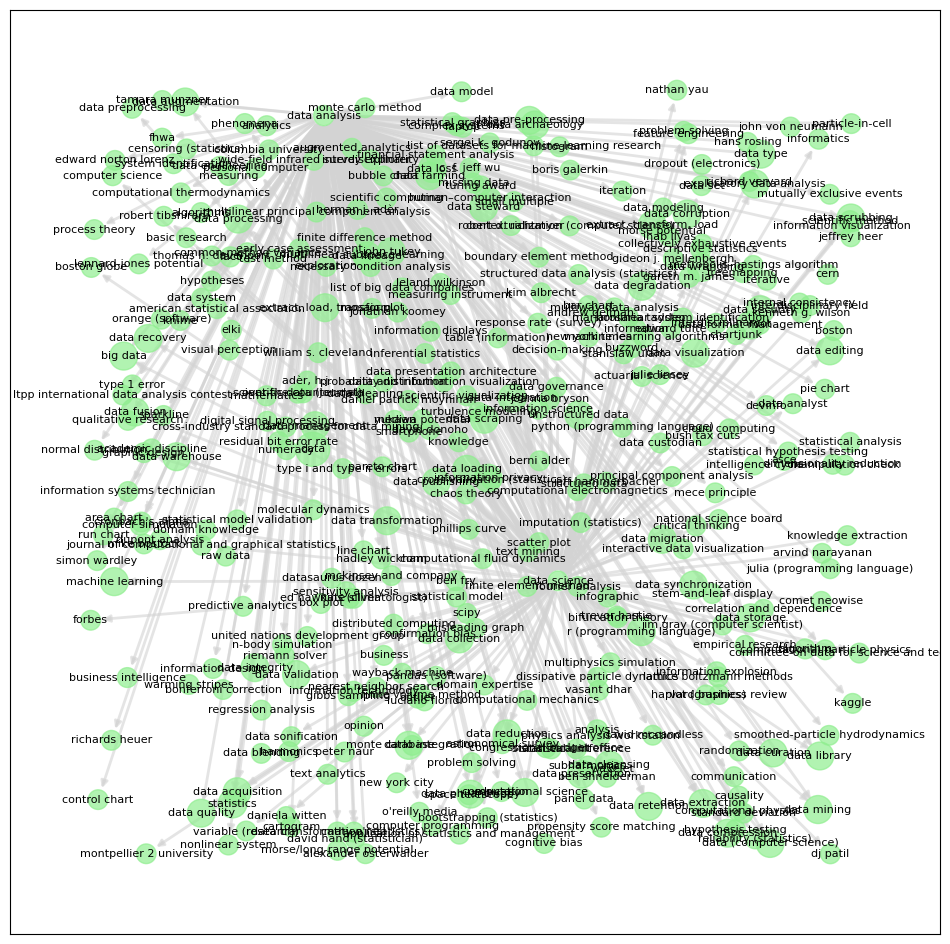

In [10]:
def remove_self_references(l): ## node connections to itself
    return [i for i in l if i[0]!=i[1]]

def add_focus_point(links, focus="on me", focus_factor=3):
    for i, link in enumerate(links):
        if not (focus in link[0] or focus in link[1]):
            links[i] = [link[0], link[1], link[2] / focus_factor]
        else:
            links[i] = [link[0], link[1], link[2] * focus_factor]

    return links

def create_graph(rg, focus=None):

    links = rg.links
    links = remove_self_references(links)
    if focus is not None:
        links = add_focus_point(links, focus)

    node_data = rg.rank_terms()
    nodes = node_data.index.tolist()
    node_weights = node_data.values.tolist()
    node_weights = [nw * 100 for nw in node_weights]
    nodelist = nodes


    G = nx.DiGraph() # MultiGraph()

    # G.add_node()
    G.add_nodes_from(nodes)

    # Add edges
    G.add_weighted_edges_from(links)

    pos = nx.random_layout(G, seed=17)  # positions for all nodes - seed for reproducibility

    fig = plt.figure(figsize=(12,12))

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodelist,
        node_size=node_weights,
        node_color='lightgreen',
        alpha=0.7
    )

    widths = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edges(
        G, pos,
        edgelist = widths.keys(),
        width=list(widths.values()),
        edge_color='lightgray',
        alpha=0.6
    )

    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),font_size=8,
                            font_color='black')

    plt.show()

ng = simplify_graph(rg, 5)

create_graph(ng)

In [15]:
from langchain.memory import ConversationKGMemory
from langchain.chains import ConversationChain
from langchain.prompts.prompt import PromptTemplate
from langchain.llms import VertexAI

In [13]:
llm = VertexAI(
    model_name="gemini-1.0-pro",
    max_output_tokens=256,
    temperature=0.1,
    verbose=False,
    )

memory = ConversationKGMemory(llm=llm, return_messages=True)

GoogleAuthError: Unable to find your project. Please provide a project ID by:
- Passing a constructor argument
- Using vertexai.init()
- Setting project using 'gcloud config set project my-project'
- Setting a GCP environment variable
- To create a Google Cloud project, please follow guidance at https://developers.google.com/workspace/guides/create-project